# Projet – Analyse temporelle du Bitcoin
Nom : Ayad-Zeddam Malik | Lopez Valentin | Abgarov Artur | Razafindratsima Nathan 

Cours : 8PRO408

Ce projet a pour objectif de réaliser une analyse exploratoire des données de prix et de volume du Bitcoin à partir d’un fichier de données à fréquence 1 minute. L’étude porte principalement sur l’évolution du prix de clôture et du volume des transactions, ainsi que sur les relations entre ces variables dans le temps. Les résultats présentés sont descriptifs et ne constituent pas des recommandations d’investissement.



In [99]:
# Bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [131]:
# Chargement du fichier CSV
df = pd.read_csv("btcusd_1-min_data.csv")

# Afficher les 5 premières lignes
print("Aperçu du dataset (5 premières lignes)")
display(df.head(5))

# Afficher les informations sur le DataFrame
print("\nInformations sur le dataframe\n")
df.info()

# Afficher les statistiques descriptives
print("\nStatistiques descriptives")
df.describe()



Aperçu du dataset (5 premières lignes)


,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0



Informations sur le dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7329277 entries, 0 to 7329276
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 335.5 MB

Statistiques descriptives


,Timestamp,Open,High,Low,Close,Volume
count,7.329277e+06,7.329277e+06,7.329277e+06,7.329277e+06,7.329277e+06,7.329277e+06
mean,1.545294e+09,2.135825e+04,2.136591e+04,2.135037e+04,2.135825e+04,5.123912e+00
std,1.269528e+08,3.002243e+04,3.003062e+04,3.001412e+04,3.002243e+04,2.205107e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.435351e+09,4.436700e+02,4.438800e+02,4.434500e+02,4.436600e+02,1.973493e-02
50%,1.545290e+09,7.299530e+03,7.303050e+03,7.295060e+03,7.299580e+03,4.488724e-01
75%,1.655229e+09,3.092879e+04,3.095000e+04,3.090755e+04,3.092961e+04,2.895686e+00
max,1.765238e+09,1.262020e+05,1.262720e+05,1.261580e+05,1.262020e+05,5.853852e+03


## 2. Préparation des données temporelles
Conversion du Timestamp en date et vérification de la qualité des données.

Les horodatages sont convertis en dates calendaires, puis les lignes sont triées chronologiquement afin de garantir la cohérence temporelle de l’analyse. Aucune valeur manquante ni doublon significatif n’a été détecté, ce qui permet de travailler directement sur les données brutes.

In [132]:
# Conversion des dates en date calendaire
df["Date"] = pd.to_datetime(df["Timestamp"], unit="s")

print("Aperçu de df_heure (5 premières lignes")
df.head(5)

Aperçu de df_heure (5 premières lignes


,Timestamp,Open,High,Low,Close,Volume,Date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00


In [102]:
#Tri du DataFrame par ordre chronologique
df = df.sort_values("Date")

print("Aperçu après tri : ")
display(df.head())

# Analyse des valeurs manquantes
nombre_NA = df.isnull().sum()
print(f"Nombre de valeur manquantes : {nombre_NA}")

# Analyse des doublons
nombre_doublons= df.duplicated().sum()
print(f"Nombre de lignes en double : {nombre_doublons}")

Aperçu après tri : 


,Timestamp,Open,High,Low,Close,Volume,Date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00


Nombre de valeur manquantes : Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
Date         0
dtype: int64
Nombre de lignes en double : 0


## 3. Agrégations temporelles (heure, jour et mois)
Regroupement des données pour analyser les tendances à différentes échelles de temps.

Les données initiales sont enregistrées à la minute. Afin de lisser le bruit et de faciliter l’interprétation, nous construisons une version agrégée au jour (`df_jour`), en conservant pour chaque jour le premier cours (Open), le plus haut (High), le plus bas (Low), le dernier cours (Close) et le volume total échangé. Cette série journalière sera utilisée pour certaines visualisations et analyses complémentaires.


### 3.1 Agrégation horaire

Dans un premier temps, nous construisons une série agrégée à l’heure à partir des données à la minute. Pour chaque heure, nous conservons le premier prix (Open), le plus haut (High), le plus bas (Low), le dernier prix (Close) ainsi que le volume total échangé. Cette agrégation intermédiaire permet de lisser légèrement le bruit des données tout en conservant une granularité relativement fine.


In [103]:
#Agrégation des données par heure (OHLCV)

df_heure = df.resample("H", on="Date").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
})

print("Aperçu de df_heure (5 premières lignes")
df_heure.head(5)



Aperçu de df_heure (5 premières lignes


,Open,High,Low,Close,Volume
Date,,,,,
2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 12:00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 13:00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 14:00:00,4.58,4.58,4.58,4.58,0.0


In [104]:
df_jour = df.resample("D", on="Date").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
})

print("Aperçu de df_jour (5 premières lignes)")
df_jour.head(5)


Aperçu de df_jour (5 premières lignes)


,Open,High,Low,Close,Volume
Date,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742


In [105]:
df_mois = df.resample("M", on="Date").mean()

print("Aperçu de df_mois (5 premières lignes)")
df_mois.head()


Aperçu de df_mois (5 premières lignes)


,Timestamp,Open,High,Low,Close,Volume
Date,,,,,,
2012-01-31,1.326733e+09,6.253758,6.253799,6.253711,6.253767,0.045693
2012-02-29,1.329307e+09,5.234570,5.234590,5.234526,5.234547,0.114023
2012-03-31,1.331899e+09,4.954475,4.954491,4.954437,4.954453,0.202725
2012-04-30,1.334534e+09,4.980317,4.980339,4.980292,4.980315,0.381578
2012-05-31,1.337170e+09,5.041776,5.041785,5.041760,5.041769,0.414877


### Zoom sur certaines périodes (bull run, crash)

In [106]:
def tracer_zoom(df_jour, start, end, titre="Zoom sur une période"):
  
    # Sous-ensemble sur la période choisie
    df_zoom = df_jour.loc[start:end].copy()

    # Graphique du prix Close
    plt.figure(figsize=(10, 4))
    plt.plot(df_zoom.index, df_zoom["Close"], label="Prix de clôture", color="blue")
    plt.title(f"{titre} ({start} → {end})")
    plt.xlabel("Date")
    plt.ylabel("Prix ($)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Statistique : variation en %
    variation_pct = (df_zoom["Close"].iloc[-1] - df_zoom["Close"].iloc[0]) / df_zoom["Close"].iloc[0] * 100
    print(f"Variation du prix sur la période : {variation_pct:.2f} %")


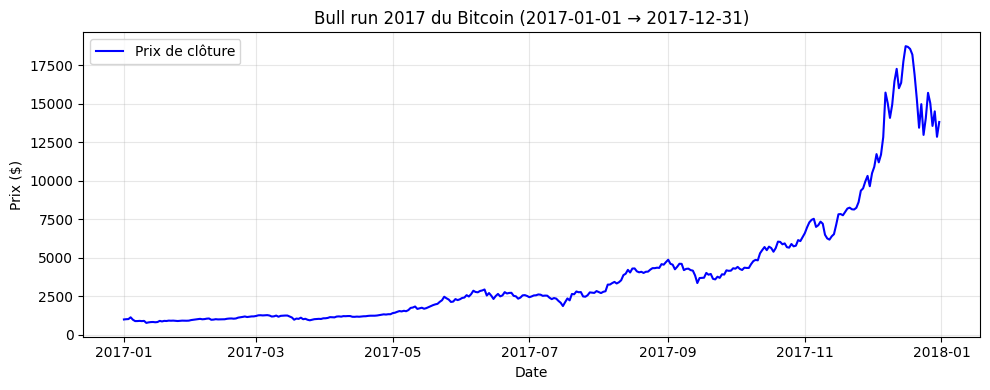

Variation du prix sur la période : 1286.06 %


In [107]:
# Bull run historique de 2017
tracer_zoom(
    df_jour,
    start="2017-01-01",
    end="2017-12-31",
    titre="Bull run 2017 du Bitcoin"
)

On observe sur 2017 une hausse très marquée du prix du Bitcoin, avec une
progression quasi continue sur l’année. La courbe présente plusieurs phases
d’accélération suivies de corrections, typiques d’un marché en bull run.
La variation totale sur la période est de 1286 % confirme l’ampleur de la hausse.

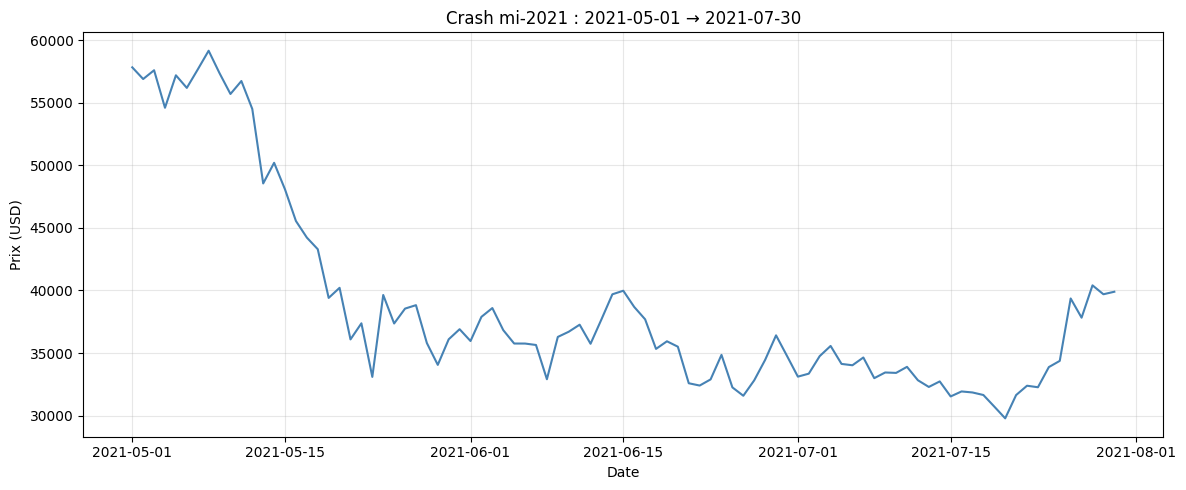

Variation sur la période : -30.99 %


In [108]:
#Crash mi 2021
plot_zoom(
    df_jour,
    start="2021-05-01",
    end="2021-07-30",
    title="Crash mi-2021"
)


Le graphique montre le crash du Bitcoin entre mai et juillet 2021. Le prix chute
rapidement d’environ 59 000 dollars à près de 29 000 dollars, soit une baisse de plus de 30 %.
La période est marquée par une forte volatilité et plusieurs tentatives de rebond
qui échouent avant une reprise plus nette fin juillet.


## 4. Analyse univariée du prix de clôture (Close)
Cette section analyse la distribution, la dispersion et la présence d’éventuelles valeurs aberrantes du prix de clôture du Bitcoin.


In [109]:
print("Statistiques descriptives du prix de clôture")
df["Close"].describe()


Statistiques descriptives du prix de clôture


count    7.329277e+06
mean     2.135825e+04
std      3.002243e+04
min      3.800000e+00
25%      4.436600e+02
50%      7.299580e+03
75%      3.092961e+04
max      1.262020e+05
Name: Close, dtype: float64

In [110]:
print("Indicateurs statistiques du prix :")
print(f"Asymétrie (skewness) : {df["Close"].skew()}") 



Indicateurs statistiques du prix :
Asymétrie (skewness) : 1.6431405664441188


In [111]:
print("Analyse de l'aplatissement (kurtosis) du prix :")
print(f"Kurtosis : {df["Close"].kurtosis()}") 


Analyse de l'aplatissement (kurtosis) du prix :
Kurtosis : 1.8382781942158357


### Interprétation des statistiques univariées

Le prix de clôture du Bitcoin présente une moyenne d’environ 21 331 dollars, tandis que la médiane est d’environ 7 295 dollars. Cet écart important entre la moyenne et la médiane indique une distribution fortement asymétrique vers la droite, ce qui est confirmé par la valeur du coefficient d’asymétrie (skewness ≈ 1,65).

L’écart-type élevé traduit une forte dispersion des valeurs, ce qui reflète la grande volatilité du Bitcoin au cours de la période étudiée. La valeur du kurtosis (≈ 1,85) indique une distribution présentant des valeurs extrêmes, sans toutefois être excessivement aplatie ou excessivement pointue. La valeur de kurtosis (≈ 1,85) indique une distribution légèrement leptokurtique.

Ces résultats sont cohérents avec le comportement très volatil du marché des cryptomonnaies.

### Visualisation de la distribution du prix de clôture (Close)
Cette partie permet d’observer graphiquement la répartition du prix du Bitcoin ainsi que la présence de valeurs aberrantes.


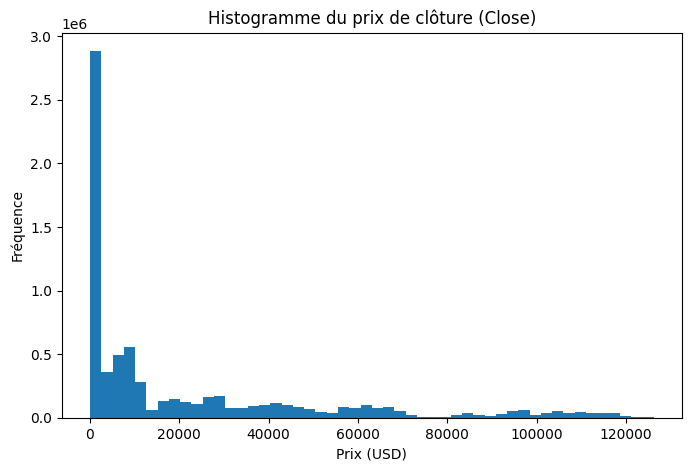

In [112]:
# Histogramme du prix de clôture :

plt.figure(figsize=(8, 5))
plt.hist(df["Close"], bins=50)
plt.title("Histogramme du prix de clôture (Close)")
plt.xlabel("Prix (USD)")
plt.ylabel("Fréquence")
plt.show()


### Interprétation de l’histogramme

L’histogramme met en évidence une très forte concentration des prix de clôture aux valeurs faibles, principalement inférieures à 10 000 dollards. La distribution présente une longue traîne vers la droite, correspondant aux périodes de forte hausse du Bitcoin avec des prix pouvant dépasser les 100 000 dollards. Cette forme confirme une asymétrie marquée à droite ainsi que la présence de valeurs extrêmes, ce qui reflète la forte volatilité du marché des cryptomonnaies.

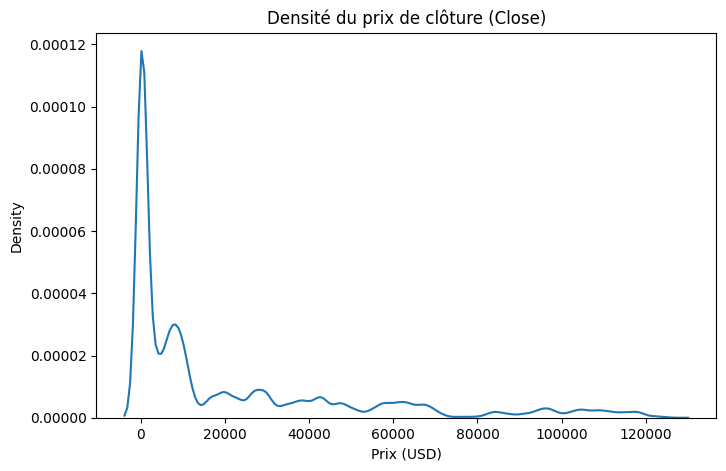

In [113]:
# Courbe de densité du prix de clôture

plt.figure(figsize=(8, 5))
sns.kdeplot(df["Close"])
plt.title("Densité du prix de clôture (Close)")
plt.xlabel("Prix (USD)")
plt.show()


### Interprétation de la courbe de densité

La courbe de densité confirme la forme très asymétrique de la distribution du prix de clôture. La plus forte concentration des valeurs se situe à des niveaux de prix faibles, correspondant aux premières années du Bitcoin. La longue traîne observée vers les valeurs élevées traduit les périodes de forte hausse du prix. Cette représentation lissée permet de mieux visualiser la structure globale de la distribution et confirme la forte volatilité du marché sur l’ensemble de la période étudiée.


### interprétation des deux graphiques

L’histogramme et la courbe de densité montrent une forte concentration des prix de clôture autour de niveaux relativement bas sur la première partie de la période, ainsi qu’une longue traîne vers les valeurs élevées, correspondant aux phases de forte hausse du Bitcoin. Cette forme confirme l’asymétrie marquée vers la droite de la distribution.


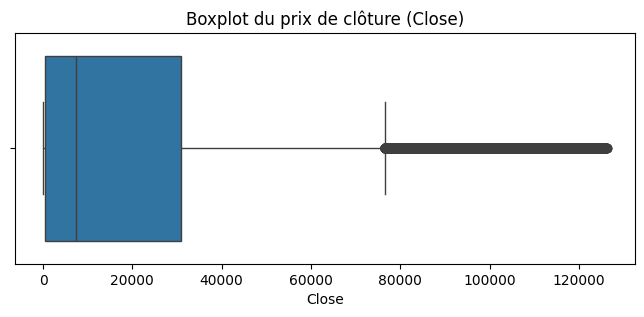

In [114]:
# Boxplot du prix clôture

plt.figure(figsize=(8, 3))
sns.boxplot(x=df["Close"])
plt.title("Boxplot du prix de clôture (Close)")
plt.show()


### Interprétation du boxplot

Le boxplot met en évidence une dispersion très importante des prix de clôture ainsi que la présence de nombreuses valeurs extrêmes situées dans la partie haute de la distribution. La majorité des observations se concentre dans la zone des prix faibles, tandis que les valeurs élevées apparaissent comme des points isolés. Cette configuration confirme la forte asymétrie à droite de la distribution ainsi que la volatilité extrême du marché du Bitcoin sur la période étudiée.


## 5. Analyse univariée du volume (Volume)
Cette section analyse la distribution, la dispersion et la présence de valeurs aberrantes du volume de transactions du Bitcoin.


In [115]:
print("Statistiques descriptives de la variable Volume")
df["Volume"].describe()


Statistiques descriptives de la variable Volume


count    7.329277e+06
mean     5.123912e+00
std      2.205107e+01
min      0.000000e+00
25%      1.973493e-02
50%      4.488724e-01
75%      2.895686e+00
max      5.853852e+03
Name: Volume, dtype: float64

In [116]:
print("Indicateurs statistiques du volume :")
print(f"Asymétrie (skewness) : {df["Volume"].skew()}") 

Indicateurs statistiques du volume :
Asymétrie (skewness) : 27.81863126274926


In [117]:
print("Analyse de l'aplatissement (kurtosis) du volume :")
print(f"Kurtosis : {df["Volume"].kurtosis()}") 



Analyse de l'aplatissement (kurtosis) du volume :
Kurtosis : 2483.039194524156


### Interprétation des statistiques univariées du volume

Le volume de transactions présente une moyenne d’environ 5,13 tandis que la médiane est proche de zéro, ce qui indique que la plupart des intervalles d’une minute sont associés à un volume très faible. Cette situation s’explique par la fréquence élevée des données : les volumes sont mesurés à la minute, ce qui conduit mécaniquement à de nombreuses observations quasi nulles, ponctuées de pics plus importants.

La valeur extrêmement élevée de la skewness environs 28 et du kurtosis d'environs 2483 traduit une distribution extrêmement asymétrique vers la droite, avec un grand nombre de valeurs faibles et quelques volumes exceptionnellement élevés. Ces valeurs extrêmes correspondent à des épisodes de forte activité sur le marché.



### Visualisation de la distribution du volume (Volume)
Cette partie permet d’observer graphiquement la répartition du volume des transactions ainsi que la présence de valeurs aberrantes.


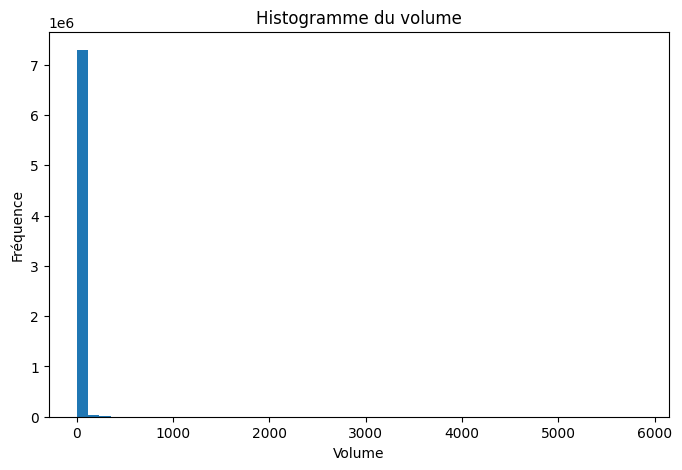

In [118]:
# Histogramme sur le volume

plt.figure(figsize=(8, 5))
plt.hist(df["Volume"], bins=50)
plt.title("Histogramme du volume")
plt.xlabel("Volume")
plt.ylabel("Fréquence")
plt.show()


### Interprétation de l’histogramme du volume

L’histogramme montre une concentration extrêmement forte des volumes à des valeurs proches de zéro, ce qui indique que la majorité des transactions par minute présentent un volume très faible. À l’inverse, quelques observations rares atteignent des valeurs de volume très élevées, allant jusqu’à plusieurs milliers. Cette configuration traduit une distribution très fortement asymétrique vers la droite et met en évidence la présence de pics ponctuels d’activité sur le marché du Bitcoin.

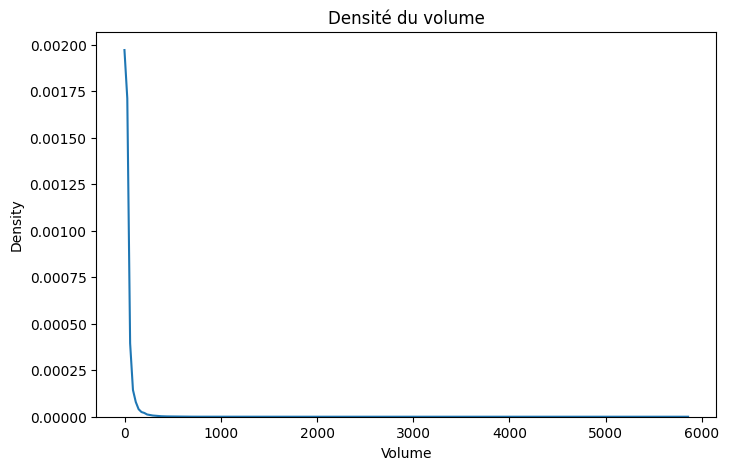

In [119]:
# Courbe du volume

plt.figure(figsize=(8, 5))
sns.kdeplot(df["Volume"])
plt.title("Densité du volume")
plt.xlabel("Volume")
plt.show()


### Interprétation de la courbe de densité du volume

La courbe de densité montre une très forte concentration des volumes à proximité de zéro, ce qui indique que la majorité des transactions présentent un volume très faible. La densité chute rapidement lorsque le volume augmente, avec une longue traîne vers les valeurs élevées. Cette forme confirme une asymétrie extrême à droite de la distribution du volume, traduisant la présence de pics ponctuels d’activité très intenses sur le marché du Bitcoin.


### Interprétation des deux graphiques

L’histogramme et la courbe de densité montrent une très forte concentration d’observations pour des volumes proches de zéro, ce qui confirme que, la plupart du temps, le volume échangé à la minute reste faible. La longue traîne vers les valeurs élevées correspond aux rares périodes où l’activité de marché est très intense. Cette structure est typique de données de volume à haute fréquence.

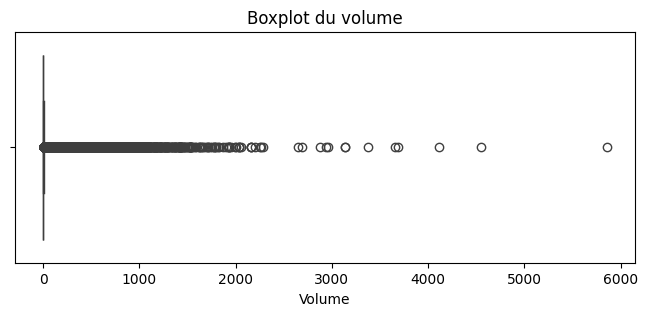

In [120]:
#Boxplot du volume

plt.figure(figsize=(8, 3))
sns.boxplot(x=df["Volume"])
plt.title("Boxplot du volume")
plt.show()


### Interprétation du boxplot du volume

Le boxplot met en évidence une très forte concentration des volumes autour de valeurs proches de zéro, ce qui confirme que la majorité des transactions présentent une activité faible. En revanche, on observe de très nombreux points atypiques situés loin du cœur de la distribution, représentant des pics de volume extrêmement élevés. Ces valeurs extrêmes traduisent des périodes ponctuelles d’activité intense sur le marché du Bitcoin, souvent associées à des épisodes de forte volatilité.

## Analyse de la tendance et de la volatilité du prix

Après l’analyse des distributions du prix et du volume, nous nous intéressons maintenant à l’évolution dynamique du prix du Bitcoin dans le temps, en particulier à sa volatilité. La volatilité permet de mesurer l’intensité des variations du prix sur une période donnée et constitue un indicateur clé du risque sur les marchés financiers.

### Volatilité glissante du prix

Afin de quantifier la volatilité du Bitcoin, nous calculons l’écart-type glissant du prix de clôture sur une fenêtre mobile de 30 jours. Cette approche permet de suivre l’évolution du niveau de risque au cours du temps et de repérer les périodes de forte instabilité du marché.


In [121]:
# Calcul de la volatilité glissante sur 30 jours
df_jour["Volatilite_30j"] = df_jour["Close"].rolling(window=30).std()

print("Aperçu des 5 premières lignes : ")
df_jour[["Close", "Volatilite_30j"]].dropna().head()


Aperçu des 5 premières lignes : 


,Close,Volatilite_30j
Date,,
2012-01-30,5.58,0.697233
2012-01-31,5.55,0.655342
2012-02-01,5.99,0.607466
2012-02-02,6.26,0.571247
2012-02-03,6.29,0.548574


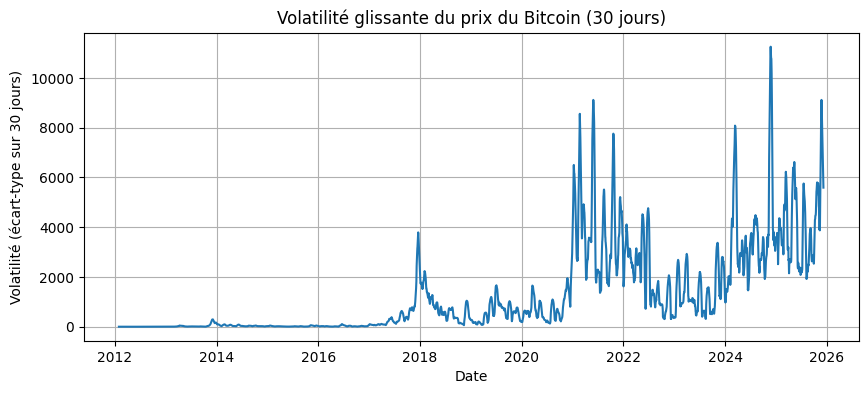

In [122]:
# Courbe de volatilité du prix

plt.figure(figsize=(10, 4))
plt.plot(df_jour.index, df_jour["Volatilite_30j"])
plt.title("Volatilité glissante du prix du Bitcoin (30 jours)")
plt.xlabel("Date")
plt.ylabel("Volatilité (écart-type sur 30 jours)")
plt.grid(True)
plt.show()


### Interprétation de la volatilité glissante

Le graphique de la volatilité glissante met en évidence les variations du niveau de risque du Bitcoin au cours du temps. On observe que la volatilité reste très faible durant les premières années, ce qui correspond à une phase de marché encore peu actif.

À partir de 2017, la volatilité augmente fortement, notamment lors des périodes de fortes hausses et de chutes brutales des prix (bull runs et krachs). Les pics les plus élevés apparaissent autour de 2018, 2021–2022 et 2024–2025, ce qui correspond à des phases de marché très instables.

Cette évolution confirme le caractère extrêmement volatil du Bitcoin, avec une intensification du risque au fil du temps. La volatilité glissante permet ainsi d’identifier clairement les périodes de tension sur le marché et constitue un indicateur essentiel pour l’analyse financière des cryptomonnaies.

## 6. Analyse bivariée entre le prix de clôture (Close) et le volume
Cette section vise à étudier la relation entre le prix du Bitcoin et le volume des transactions afin d’identifier d’éventuelles corrélations.


In [123]:
corr_close_volume = df["Close"].corr(df["Volume"])
print(f"Coefficient de corrélation entre close et volume: {corr_close_volume:.4f}")



Coefficient de corrélation entre close et volume: -0.0930


### Interprétation de la corrélation

Le coefficient de corrélation entre le prix de clôture et le volume est d’environ -0,09, ce qui indique une corrélation linéaire très faible et légèrement négative. Cela signifie qu’il n’existe pas de relation linéaire significative entre le prix du Bitcoin et le volume des transactions sur l’ensemble de la période étudiée. Les variations de prix ne sont donc pas directement expliquées par les variations du volume de manière simple et linéaire.


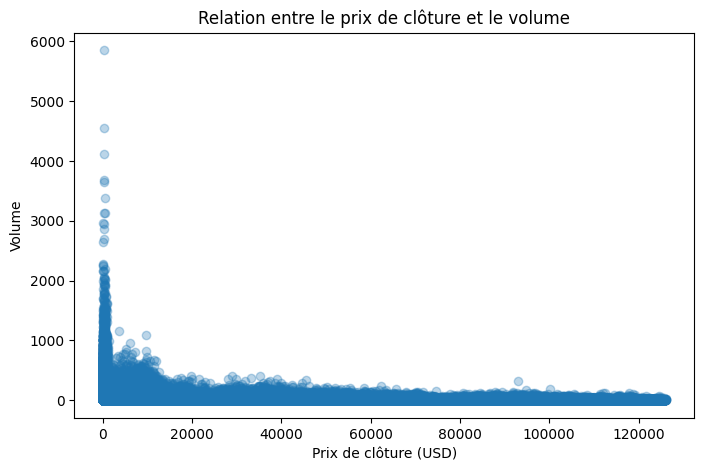

In [124]:
# Nuage de point entre close et volume

plt.figure(figsize=(8, 5))
plt.scatter(df["Close"], df["Volume"], alpha=0.3)
plt.title("Relation entre le prix de clôture et le volume")
plt.xlabel("Prix de clôture (USD)")
plt.ylabel("Volume")
plt.show()


### Interprétation du nuage de points (prix de clôture vs volume)

Le nuage de points met en évidence une très forte dispersion des observations et l’absence de relation linéaire claire entre le prix de clôture et le volume des transactions. Pour des niveaux de prix faibles comme pour des niveaux de prix élevés, le volume reste majoritairement faible, avec quelques pics isolés d’activité. Cette observation est cohérente avec la faible corrélation mesurée précédemment (≈ -0,09) et confirme que le volume n’explique pas directement les variations du prix de manière linéaire.


## 7. Matrice de corrélation entre les variables
Cette section présente la matrice de corrélation entre les différentes variables financières afin d’analyser leurs relations globales.


In [125]:
# Matrice de corrélation

print("Matrice de corrélation (Open, High, Low, Close, Volume)")
corr_matrix = df[["Open", "High", "Low", "Close", "Volume"]].corr()
corr_matrix


Matrice de corrélation (Open, High, Low, Close, Volume)


,Open,High,Low,Close,Volume
Open,1.000000,1.000000,1.000000,1.000000,-0.092947
High,1.000000,1.000000,0.999999,1.000000,-0.092891
Low,1.000000,0.999999,1.000000,1.000000,-0.093014
Close,1.000000,1.000000,1.000000,1.000000,-0.092953
Volume,-0.092947,-0.092891,-0.093014,-0.092953,1.000000


### Interprétation de la matrice de corrélation

La matrice de corrélation met en évidence une corrélation quasi parfaite entre les variables Open, High, Low et Close, avec des coefficients très proches de 1. Cela est logique, car ces variables représentent différentes mesures du prix du Bitcoin sur une même unité de temps et évoluent donc de manière très similaire.

En revanche, la variable Volume présente une corrélation faible et légèrement négative avec les variables de prix (environ -0,09). Cela indique que le volume des transactions n’est pas fortement lié de manière linéaire aux variations du prix du Bitcoin sur l’ensemble de la période étudiée. Ce résultat confirme les observations issues de l’analyse bivariée.


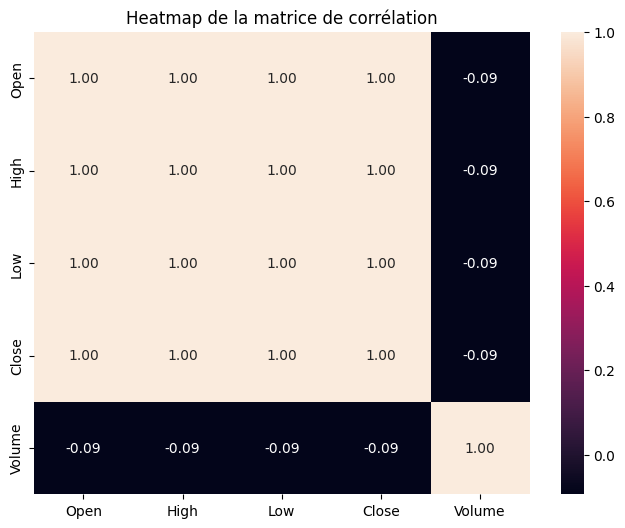

In [126]:
# Heatmap de corrélation

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Heatmap de la matrice de corrélation")
plt.show()


## Conclusion générale

Cette analyse exploratoire a permis de mieux comprendre l’évolution du prix de clôture et du volume d’échange du Bitcoin sur la période étudiée, ainsi que d’identifier les grandes tendances du marché (phases de hausse, corrections, pics d’activité). L’étude univariée a mis en évidence une distribution très asymétrique du prix, caractérisée par une forte concentration de valeurs basses et la présence de valeurs extrêmes correspondant aux phases de bull market. Cela illustre le caractère hautement volatil du Bitcoin, typique des marchés financiers spéculatifs.

Il convient de rappeler que les données utilisées sont à fréquence 1 minute, ce qui explique la présence de nombreux volumes quasi nuls et de pics d’activité ponctuels. Cette granularité élevée rend le marché particulièrement bruité à cette échelle de temps.

L’analyse du volume a révélé une distribution encore plus déséquilibrée, avec une majorité de faibles volumes et quelques périodes de volumes exceptionnellement élevés, suggérant des phases d’activité intense du marché. Les boxplots confirment la présence de nombreuses valeurs aberrantes, ce qui est cohérent avec les évènements majeurs du marché des cryptomonnaies.

L’étude bivariée entre le prix de clôture et le volume montre une corrélation faible et légèrement négative, ce qui indique que le volume seul ne suffit pas à expliquer les variations du prix du Bitcoin. Cependant, l’analyse visuelle met en évidence que les volumes les plus élevés apparaissent principalement lors des phases de prix faibles, ce qui peut notamment correspondre à des périodes d’accumulation avant les hausses de prix.

Enfin, la matrice de corrélation confirme la cohérence interne des données de prix (Open, High, Low, Close), qui évoluent de manière parfaitement synchronisée, renforçant ainsi la fiabilité du jeu de données.

L’analyse complémentaire à l’aide des moyennes mobiles et de la volatilité glissante a permis d’illustrer l’évolution de la tendance et du niveau de risque du Bitcoin au cours du temps. Les périodes de forte hausse s’accompagnent généralement d’une augmentation marquée de la volatilité, traduisant un marché instable et très sensible aux mouvements spéculatifs.

### Limites de l’analyse

Cette étude reste une analyse exploratoire basée uniquement sur des relations linéaires et des statistiques descriptives. Elle ne permet pas d’identifier des relations causales ni de modéliser précisément les dynamiques temporelles complexes du marché du Bitcoin.

De plus, l’analyse ne tient pas compte de nombreux facteurs externes (données macro-économiques, réglementations, contexte géopolitique), qui influencent fortement le prix des cryptomonnaies.

### Perspectives d’amélioration

Pour aller plus loin, cette analyse pourrait être enrichie par :
- Une étude approfondie des rendements et de la volatilité,
- Une analyse plus systématique des tendances à long terme (moyennes mobiles),
- L’intégration d’indicateurs techniques (RSI, MACD),
- L’intégration de modèles de prévision temporelle plus avancés.

En conclusion, cette analyse exploratoire constitue une base solide pour comprendre le comportement du marché du Bitcoin, et ouvre la voie à des analyses prédictives plus avancées.

Afin d’aller un peu plus loin dans l’analyse et d’illustrer l’utilisation d’outils simples d’analyse technique, une étude complémentaire basée sur les moyennes mobiles et la volatilité glissante est proposée à titre purement exploratoire.


## Analyse complémentaire (Bonus) : Moyennes mobiles et tendance

Cette section propose une extension exploratoire de l’étude à l’aide des moyennes mobiles, afin d’observer la tendance générale du prix du Bitcoin. Cette partie est donnée à titre illustratif et ne constitue pas un modèle de prédiction fiable.


In [127]:
# 16. Calcul des moyennes mobiles (30 jours et 90 jours)

print("Calcul des moyennes mobiles 30j et 90j : ") 
df_jour["MM_30"] = df_jour["Close"].rolling(window=30).mean()
df_jour["MM_90"] = df_jour["Close"].rolling(window=90).mean()

df_jour[["Close", "MM_30", "MM_90"]].tail()


Calcul des moyennes mobiles 30j et 90j : 


,Close,MM_30,MM_90
Date,,,
2025-12-04,92103.0,94071.633333,106983.877778
2025-12-05,89348.0,93587.733333,106751.933333
2025-12-06,89249.0,93186.566667,106508.655556
2025-12-07,90405.0,92757.566667,106267.622222
2025-12-08,90642.0,92369.433333,106035.522222


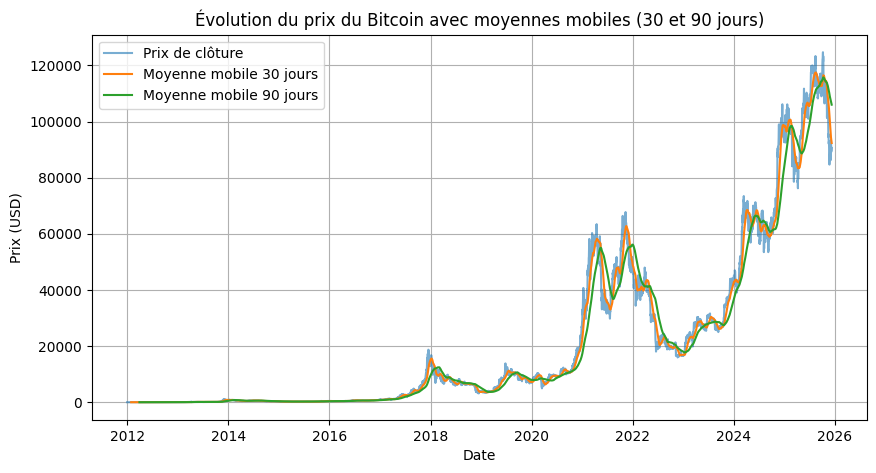

In [128]:
# Visualisation : prix du Bitcoin et moyennes mobiles 30j et 90j
 
plt.figure(figsize=(10, 5))
plt.plot(df_jour.index, df_jour["Close"], label="Prix de clôture", alpha=0.6)
plt.plot(df_jour.index, df_jour["MM_30"], label="Moyenne mobile 30 jours")
plt.plot(df_jour.index, df_jour["MM_90"], label="Moyenne mobile 90 jours")

plt.title("Évolution du prix du Bitcoin avec moyennes mobiles (30 et 90 jours)")
plt.xlabel("Date")
plt.ylabel("Prix (USD)")
plt.legend()
plt.grid(True)
plt.show()


### Interprétation des moyennes mobiles

Le graphique met en évidence l’évolution du prix de clôture du Bitcoin ainsi que deux moyennes mobiles calculées sur 30 jours et 90 jours. La moyenne mobile à 30 jours suit de plus près les variations du prix et reflète la tendance à court terme, tandis que la moyenne mobile à 90 jours est plus lissée et représente la tendance de fond. On observe plusieurs phases de forte hausse suivies de corrections, notamment autour des années 2017–2018, 2021–2022 et 2024–2025. Ce type d’indicateur permet de mieux visualiser les cycles du marché et d’identifier les périodes de retournement de tendance, sans toutefois permettre de faire une prédiction fiable.


In [129]:
# Projection simple basée sur la dernière moyenne mobile
dernier_prix = df_jour["Close"].iloc[-1]
dernier_mm30 = df_jour["MM_30"].iloc[-1]

print(f"Dernier prix observé      : {dernier_prix:.2f} USD")
print(f"Dernière MM 30 jours      : {dernier_mm30:.2f} USD")


Dernier prix observé      : 90642.00 USD
Dernière MM 30 jours      : 92369.43 USD


### Interprétation de la tendance récente

Le dernier prix de clôture du Bitcoin est inférieur à sa moyenne mobile à 30 jours, ce qui suggère une dynamique baissière à court terme. Cette situation peut traduire une phase de correction après une période de hausse. Toutefois, cette analyse repose uniquement sur un indicateur simple et ne permet en aucun cas d’anticiper avec certitude l’évolution future du marché.


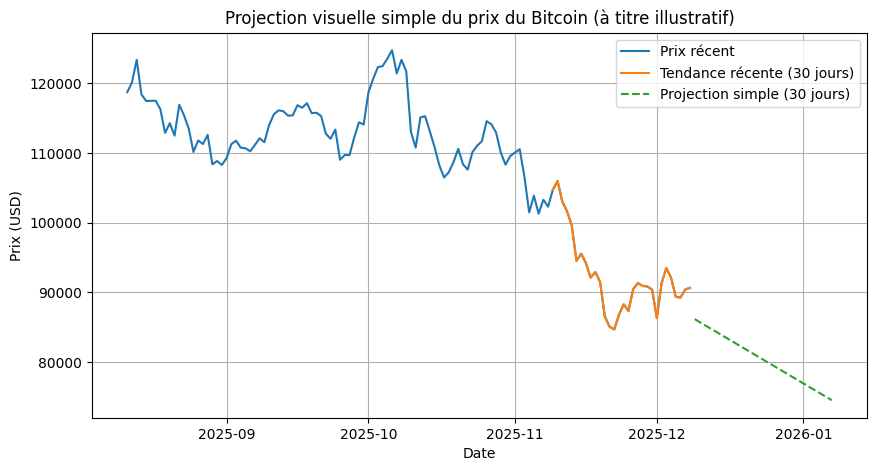

In [130]:
# Création d’une projection linéaire simple basée sur la tendance récente (30 derniers jours)

# Nombre de jours à projeter
periode_projection = 30

# x_historique : indices 0 à 29
x_historique = np.arange(30)

# y_historique : valeurs réelles des 30 derniers jours
y_historique = df_jour["Close"].tail(30).values

# Ajustement d'un modèle linéaire simple (régression de degré 1)
coef = np.polyfit(x_historique, y_historique, 1)
tendance = np.poly1d(coef)

# Construction de la projection sur les 30 prochains jours
x_future = np.arange(30, 30 + periode_projection)
y_future = tendance(x_future)

# Génération des dates futures 
dates_futures = pd.date_range(start=df_jour.index[-1] + pd.Timedelta(days=1),periods=periode_projection)


# Visualisation de la tendance
plt.figure(figsize=(10, 5))

plt.plot(df_jour.index[-120:], df_jour["Close"].tail(120), label="Prix récent")
plt.plot(df_jour.index[-30:], y_historique, label="Tendance récente (30 jours)")
plt.plot(dates_futures, y_future, "--", label="Projection simple (30 jours)")

plt.title("Projection visuelle simple du prix du Bitcoin (à titre illustratif)")
plt.xlabel("Date")
plt.ylabel("Prix (USD)")
plt.legend()
plt.grid(True)
plt.show()


### Interprétation de la projection visuelle du prix

Cette projection visuelle repose uniquement sur l’évolution récente du prix via une régression linéaire simple ajustée sur les 30 derniers prix de clôture. On observe que la tendance récente est orientée à la baisse, ce qui se traduit par une prolongation visuelle de cette dynamique dans la projection. La trajectoire projetée suggère donc une poursuite du mouvement baissier à court terme.

Cependant, on peut remettre en question la fiabilité de ce résultat, car il ne repose sur aucun modèle de prédiction entraîné ni sur une approche statistique avancée. De plus, cette projection ne prend pas en compte de nombreux facteurs macro-économiques essentiels, tels que l’inflation, les taux d’intérêt, les annonces réglementaires ou encore le contexte géopolitique.

Enfin, le Bitcoin étant une cryptomonnaie, son prix reste extrêmement volatil et peut subir des hausses ou des baisses soudaines et imprévisibles. Cette instabilité renforce le caractère purement illustratif de la projection réalisée.

